# Predicting UFC Fights

Thanks to the original author for providing the inital logic for scraping the data. Also some good ideas for the model. However, there are a few things I'd like to change. Ultimately, I think I'm going to go in a different direction. But the inital code provides a good starting point

The original project is here:
https://towardsdatascience.com/predicting-ufc-fights-with-machine-learning-5d66b58e2e3akA

Steps
1) Run scraper and collect the data, ensuring you have updated data for each fighter and bout.
2) Create fighter_bouts_joined table from scraped_data.db using <project_root>/SQL/fighter_botus_join_query.sql
3) Clean/Format/Explore data
4) Impute reach by regressing on dimensions of X

Todo/questions:
is harder to predict fights as rankings increase?
Fix imputation:
Reach
Data to get
Walk around weight
Rematch? Who won the first time
Did he  beat someone that other lost to?
Parse styles
ranking
Plots
Weight vs reach
Height vs reach
Height vs weight
Weight distribution
Height dist
Reach | height dist
Scale data
Check for multi colliniearity
Features to create
Win loss ratio
Split record to win/loss/draw/no contest
Finish round avg
Extract from website
Total strikes thrown
Total takedowns attempted
Knockdowns
Wins by KO/stoppage/submission/decision
Fights on specific days to look at if age determines fight wins
Does number of times KO’d determine anything
Look at dists of features conditioned on weight or height or ranking
Look at outliers
Plost dists after robust
Try standard scaler
Plot missingness using nullity matrix
Look at Reach predictions distribution


#### feature abbreviation meanings

SLpM - Significant Strikes Landed per Minute
Str. Acc. - Significant Striking Accuracy
SApM - Significant Strikes Absorbed per Minute
Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)
TD Avg. - Average Takedowns Landed per 15 minutes
TD Acc. - Takedown Accuracy
TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)
Sub. Avg. - Average Submissions Attempted per 15 minutes

In [89]:
import os, sys
from pathlib import Path
import pandas as pd
import sqlite3
import processor
import numpy as np

sys.path.insert(0, os.path.abspath('/home/justin/pycharmprojects/fight_predictor/predictor/'))
# pd.options.display.float_format = '{:,.2f}'.format

In [215]:
# project_root = Path("/home/justin/projects/fight_predictor")
project_root = Path("/home/justin/pycharmprojects/fight_predictor")
data_dir = project_root / "predictor" / "Data" / "Scraped_Data"
scrapers_dir = project_root / "predictor" / "scrapers"
# fighters = pd.read_csv(data_dir / "scraped_fighters.csv")

In [216]:
# dbpath = scrapers_dir / 'db' / 'scraped_data.db'
dbpath = scrapers_dir  / 'db' / 'scraped_data.db.bak5'
print(dbpath)
# /home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db

/home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db.bak5


In [217]:
cnx = sqlite3.connect(dbpath)

Run if fighter_bouts_join table doesn't exist

In [218]:
# with (project_root / "SQL" / "fighter_bouts_join_query.sql").open() as sql_file:
#     sql_script = sql_file.read()
#     cnx.cursor().executescript(sql_script)
#     cnx.commit()
#     cnx.close()


#fbjdb.to_csv(data_dir / "fighter_bouts_joined.csv")

In [219]:
fdf = pd.read_sql_query("SELECT * FROM fighters", cnx)
bdf = pd.read_sql_query("SELECT * FROM bouts", cnx)
# fbdf = pd.read_sql_query("SELECT * FROM fighter_bouts_joined", cnx)

In [220]:
bdf.describe()

,pass_stat_f1,pass_stat_f2,round_,str_stat_f1,str_stat_f2,sub_stat_f1,sub_stat_f2,td_stat_f1,td_stat_f2,time
count,6940.000000,6940.000000,6940.000000,6940.00000,6940.000000,6940.000000,6940.000000,6940.000000,6940.000000,6940.000000
mean,0.539914,0.254755,2.334438,0.36830,0.064121,1.456484,0.669741,42.472478,28.042219,3.670336
std,0.949355,0.696852,1.013724,0.61031,0.269095,1.983789,1.192705,34.002869,26.527802,1.709661
min,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,17.000000,7.000000,2.290000
50%,0.000000,0.000000,3.000000,0.00000,0.000000,1.000000,0.000000,35.000000,21.000000,4.470000
75%,1.000000,0.000000,3.000000,1.00000,0.000000,2.000000,1.000000,60.000000,41.000000,5.000000
max,10.000000,7.000000,5.000000,5.00000,3.000000,21.000000,11.000000,445.000000,271.000000,18.000000


In [221]:
# bdf.isnull().sum()

# print(bdf[bdf["pass_stat_f1"] == 0]["pass_stat_f1"].count())
# print(bdf[bdf["pass_stat_f2"] == 0]["pass_stat_f2"].count())
# print(bdf[bdf["pass_stat_f1"] == 0]["pass_stat_f1"].count())
# print(bdf[bdf["pass_stat_f2"] == 0]["pass_stat_f2"].count())
# print(bdf[bdf["str_stat_f1"] == 0]["str_stat_f1"].count())
# print(bdf[bdf["str_stat_f2"] == 0]["str_stat_f2"].count())
# print(bdf[bdf["sub_stat_f1"] == 0]["sub_stat_f1"].count())
# print(bdf[bdf["sub_stat_f2"] == 0]["sub_stat_f2"].count())
# print(bdf[bdf["td_stat_f1"] == 0]["td_stat_f2"].count())
# print(bdf[bdf["td_stat_f2"] == 0]["td_stat_f2"].count())
# print(bdf[bdf["time"] == 0]["time"].count())
#

In [222]:
# name = "Anderson Silva"
# bdf[(bdf.fighter1 == name) | (bdf.fighter2 == name)]

### Inspect Fighter dataframe

Look at distributions. Search for potential outliers.

In [223]:
fdf.describe()

,reach,sapm,slpm,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight
count,2000.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3846.000000
mean,71.666500,3.068990,2.372708,35.275115,42.541560,0.629398,26.307241,1.245992,38.784294,171.435257
std,4.224358,2.758817,1.929794,20.540777,22.603824,1.585970,28.872155,1.954198,34.374913,39.754295
min,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000
25%,69.000000,1.530000,0.800000,26.000000,35.000000,0.000000,0.000000,0.000000,0.000000,145.000000
50%,72.000000,2.870000,2.270000,40.000000,50.000000,0.000000,22.000000,0.570000,42.000000,170.000000
75%,75.000000,4.120000,3.530000,49.000000,58.000000,0.700000,45.000000,1.930000,66.000000,185.000000
max,84.000000,52.500000,22.110000,100.000000,100.000000,23.700000,100.000000,32.140000,100.000000,770.000000


Using a nullity matrix is my favorite way of immediately viewing missing data. We can see dob, and reach are missing a quite a few values, and they are important features. We will try to predict reach by regressing on the other columns. DOB might be a bit trickier. Perhaps we can think of a clever way to estimate those values.

<AxesSubplot:>

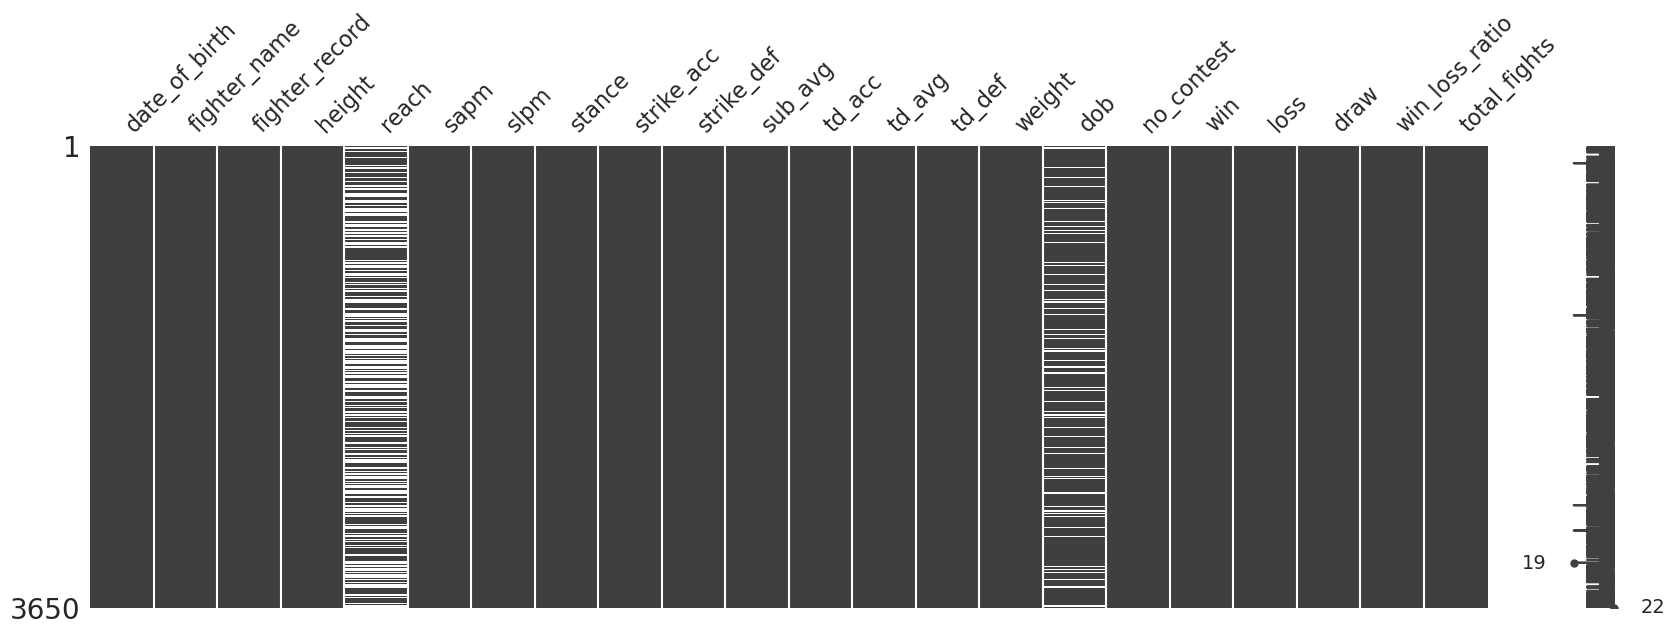

In [229]:
import missingno as mno

mno.matrix(fdf, figsize = (20, 6))

In [224]:
replacedash = lambda x: np.nan if x == "--" else x
fdf["dob"] = fdf["date_of_birth"].apply(replacedash)
fdf["dob"] = pd.to_datetime(fdf["dob"])
# fdf.head(20)

Plot at obvious correlations. This points out the weight classes condition a lot of the features. This is good to know.

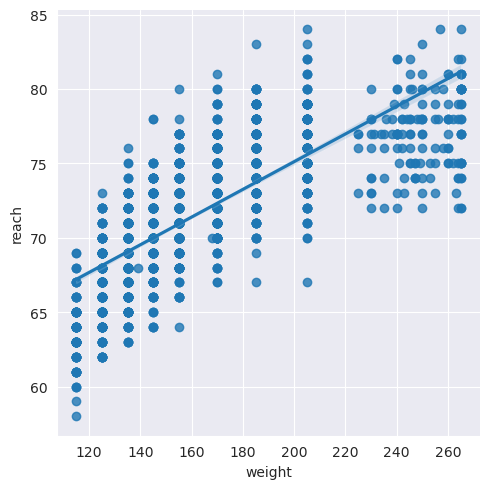

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

tempdf = fdf[["weight", "reach"]].dropna()
sns.lmplot(data=tempdf, x="weight", y="reach")
plt.show()

In [226]:
fdf.head()

,date_of_birth,fighter_name,fighter_record,height,reach,sapm,slpm,stance,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight,dob
0,Mar 02 1992,Hunter Azure,Record: 9-2-0,"5' 8""",69.0,2.08,3.92,Orthodox,53,58,1.3,34,1.97,67,145.0,1992-03-02
1,Jul 17 1990,Michael Byrnes,Record: 5-3-0,"5' 11""",NaN,0.00,0.00,,0,0,0.0,0,0.00,0,155.0,1990-07-17
2,Feb 07 1989,Gleidson Cutis,Record: 7-4-0,"5' 9""",NaN,8.28,2.99,Orthodox,52,59,0.0,0,0.00,0,155.0,1989-02-07
3,Aug 11 1990,Rolando Dy,Record: 9-7-1 (1 NC),"5' 8""",69.0,4.47,3.04,Orthodox,37,52,0.0,20,0.30,68,145.0,1990-08-11
4,Jul 27 1986,Jessica Eye,Record: 15-11-0 (1 NC),"5' 6""",66.0,4.19,3.86,Orthodox,37,55,0.5,40,0.58,57,125.0,1986-07-27


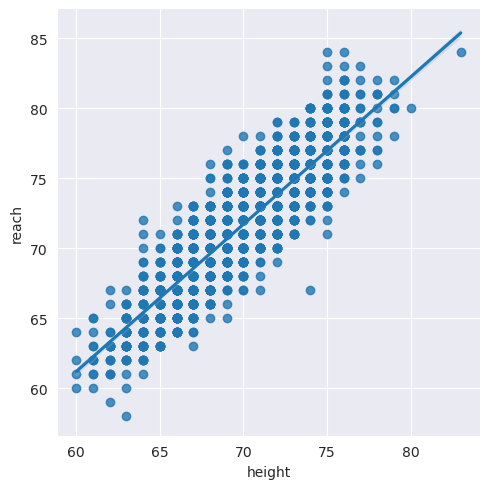

In [227]:
def parse_fighter_height(height):
    if height:
        if '"' in height:
            height = height.replace('"', '')
        ht = height.split("' ")
        ft = float(ht[0])
        inch = float(ht[1])

        return (12 * ft) + inch
    else:
        pass


fdf = fdf[fdf["height"] != "--"]
fdf["height"] = fdf["height"].apply(lambda x: parse_fighter_height(x))
tempdf = fdf[["height", "reach"]].dropna()
sns.lmplot(data=tempdf, x="height", y="reach")
plt.show()

In [108]:
# import re
# # s = "Record: 19-7-1 (1 NC)"
# s2 = "Record: 9-7-1"
# s3 = "Record: 90-7-1"
# s4 = "Record: 19-7-1"
# s5 = "Record: 534-7-1"
# # val = re.search('\(([^)]+)', s2)
#
# # sp = s2.split("-")
# # sp = s3.split("-")
# # sp = s4.split("-")
# sp = s5.split("-")
# print(sp)
# match = re.search('[0-9]+', sp[0])
# print(match)
# i = match.start()
# j = match.end()
# print(i, j)
# print(sp[0][i:j])

Parse the fighter record into win, loss, draw, and no contest columns. Also, create the features win/loss ratio total record. These might be useful.

In [228]:
import re


def parse_nocontest(x):
    if "NC" in x:
        nc_record = re.search('\(([^)]+)', x).group(1)[0]
        return int(nc_record)
    return 0


def parse_record(x):
    sp = x.split("-")
    match = re.search('[0-9]+', sp[0])
    win = int(sp[0][match.start():match.end()])
    loss, draw = int(sp[1]), int(sp[2][0])
    ratio = win/loss if win != 0 and loss != 0 else 0
    return pd.Series([win, loss, draw, ratio])


fdf["no_contest"] = fdf.fighter_record.apply(parse_nocontest)
fdf[["win", "loss", "draw", "win_loss_ratio"]] = fdf.fighter_record.apply(parse_record)
fdf["total_fights"] = fdf["win"] + fdf["loss"] + fdf["draw"] + fdf["no_contest"]
# fdf["win_loss_ratio"] = (fdf["win"] / fdf["loss"]).round(3)
fdf

,date_of_birth,fighter_name,fighter_record,height,reach,sapm,slpm,stance,strike_acc,strike_def,...,td_avg,td_def,weight,dob,no_contest,win,loss,draw,win_loss_ratio,total_fights
0,Mar 02 1992,Hunter Azure,Record: 9-2-0,68.0,69.0,2.08,3.92,Orthodox,53,58,...,1.97,67,145.0,1992-03-02,0,9.0,2.0,0.0,4.500000,11.0
1,Jul 17 1990,Michael Byrnes,Record: 5-3-0,71.0,NaN,0.00,0.00,,0,0,...,0.00,0,155.0,1990-07-17,0,5.0,3.0,0.0,1.666667,8.0
2,Feb 07 1989,Gleidson Cutis,Record: 7-4-0,69.0,NaN,8.28,2.99,Orthodox,52,59,...,0.00,0,155.0,1989-02-07,0,7.0,4.0,0.0,1.750000,11.0
3,Aug 11 1990,Rolando Dy,Record: 9-7-1 (1 NC),68.0,69.0,4.47,3.04,Orthodox,37,52,...,0.30,68,145.0,1990-08-11,1,9.0,7.0,1.0,1.285714,18.0
4,Jul 27 1986,Jessica Eye,Record: 15-11-0 (1 NC),66.0,66.0,4.19,3.86,Orthodox,37,55,...,0.58,57,125.0,1986-07-27,1,15.0,11.0,0.0,1.363636,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,Jun 29 1983,Ricky Rainey,Record: 12-6-0,73.0,77.0,2.62,2.55,Switch,48,46,...,0.95,55,170.0,1983-06-29,0,12.0,6.0,0.0,2.000000,18.0
3918,Dec 07 1974,Amir Rahnavardi,Record: 11-10-0,72.0,NaN,0.00,0.67,Orthodox,25,100,...,0.00,50,205.0,1974-12-07,0,11.0,10.0,0.0,1.100000,21.0
3919,Jan 06 1981,Josh Rafferty,Record: 9-8-0,72.0,NaN,3.60,0.60,Orthodox,33,50,...,0.00,0,170.0,1981-01-06,0,9.0,8.0,0.0,1.125000,17.0
3920,--,Gilbert Rael,Record: 1-3-0,68.0,NaN,7.46,0.00,,0,37,...,4.86,0,155.0,NaT,0,1.0,3.0,0.0,0.333333,4.0


Plot the correlation heatmap to view any obvious correlations. There are a few highly correlated features, like (height, reach) and (weight, reach), but this doesn't mean we should remove the features necessarily. Each feature still provides independent pieces of information I think. For instance, a height and reach might be related, but height and reach could still affect the fight independently.

/tmp/ipykernel_6832/2797376688.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(corcolsdf.corr())


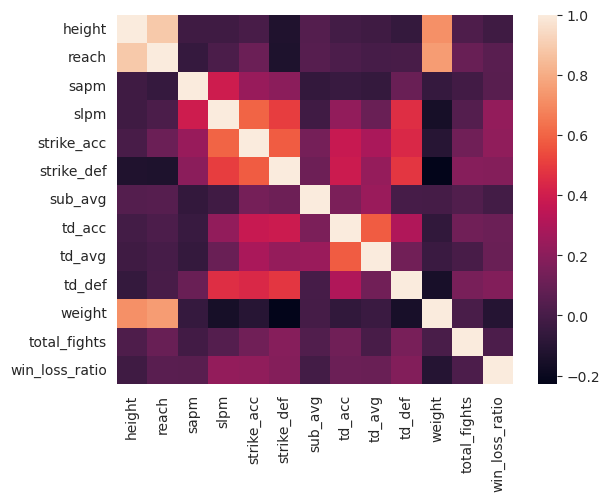

In [130]:
# columns = ['date_of_birth', 'fighter_name', 'fighter_record', 'height', 'reach',
#        'sapm', 'slpm', 'stance', 'strike_acc', 'strike_def', 'sub_avg',
#        'td_acc', 'td_avg', 'td_def', 'weight', 'dob', 'no_contest', 'win',
#        'loss', 'draw', 'total_fights', 'win_loss_ratio']
correlation_columns = ['height', 'reach', 'sapm', 'slpm',
                       'stance', 'strike_acc', 'strike_def',
                       'sub_avg', 'td_acc', 'td_avg', 'td_def',
                       'weight', 'total_fights', 'win_loss_ratio']

# sns.pairplot(fdf[correlation_columns])
corcolsdf = fdf[correlation_columns]
sns.heatmap(corcolsdf.corr())
plt.show()

In [131]:
# Create correlation matrix
corr_matrix = corcolsdf.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

/tmp/ipykernel_6832/759920943.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corcolsdf.corr().abs()
/tmp/ipykernel_6832/759920943.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,height,reach,sapm,slpm,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight,total_fights,win_loss_ratio
height,NaN,0.886682,0.027138,0.025259,0.004519,0.125197,0.039699,0.010624,0.026869,0.059380,0.721169,0.021868,0.027626
reach,NaN,NaN,0.052039,0.014016,0.107904,0.131577,0.045546,0.019998,0.000573,0.003517,0.754674,0.099370,0.054128
sapm,NaN,NaN,NaN,0.392108,0.236662,0.199030,0.062118,0.043800,0.059399,0.106378,0.053038,0.017440,0.053579
slpm,NaN,NaN,NaN,NaN,0.600601,0.505000,0.022191,0.220770,0.104112,0.458769,0.156257,0.042644,0.224649
strike_acc,NaN,NaN,NaN,NaN,NaN,0.578807,0.136801,0.373107,0.288292,0.440427,0.101190,0.124966,0.212484
strike_def,NaN,NaN,NaN,NaN,NaN,NaN,0.113119,0.389962,0.229227,0.484644,0.229328,0.187869,0.180276
sub_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156489,0.242085,0.000057,0.003938,0.034072,0.010769
td_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579144,0.306304,0.066949,0.122049,0.106910
td_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129186,0.039534,0.004685,0.103323
td_def,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151105,0.147189,0.177446


In [132]:
# Correlated pairs
# (height, reach) .8
# (strike_acc, slpm) .6
# (strike_def, slpm) .5
# (strike_acc, strike_def) .57
# (td_acc, td_avg) .58
# (weight, height) .72
# (weight, reach) .75

The original author of this project imputed fighter reach using the mean. This is potentially biasing the model: reach is probably a strong predictor of fight success, interacting with variables like strike_acc to create an effect. Also, the distribution of reach changes when conditioned on height, so we know that using overall population mean for reach is probably not a good idea

Can we estimate fighter reach by regressing on other dimensions of the fighter?

In [156]:
# USE TEMP PAST THIS POINT!

import sklearn
from sklearn.model_selection import train_test_split

columns = ['height', 'sapm', 'slpm', 'strike_acc', 'strike_def', 'sub_avg',
           'td_acc', 'td_avg', 'td_def', 'weight', 'no_contest', 'win',
           'loss', 'draw', 'total_fights', 'win_loss_ratio', 'reach']

# DROP NA!
temp = fdf[columns].dropna()

In [158]:
temp = sklearn.utils.shuffle(temp)
columns = ['height', 'sapm', 'slpm', 'strike_acc', 'strike_def', 'sub_avg',
           'td_acc', 'td_avg', 'td_def', 'weight', 'total_fights', 'win_loss_ratio']
X, y = temp[columns], temp["reach"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [191]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [192]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

f = linear_model.LinearRegression()
f.fit(X_train, y_train)
reach_predictions = f.predict(X_test)
mse = mean_squared_error(y_test, reach_predictions)
r2 = mean_squared_error(y_test, reach_predictions)

In [182]:
print(f"MSE: {mse}")
print(f"r2: {r2}")

MSE: 3.3511988823955026
r2: 3.3511988823955026


After imputing the values using regression, we plot height vs reach. So far, this function

looks like a reasonable approximator

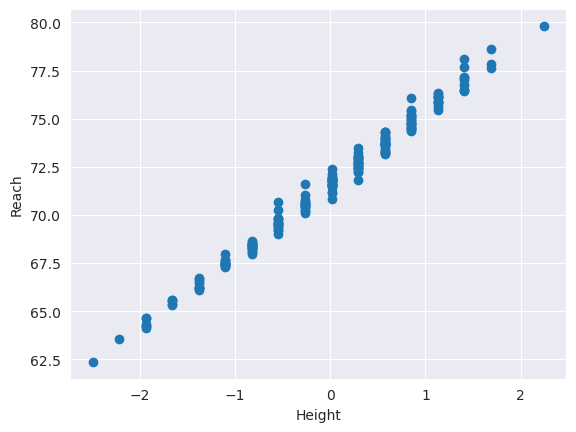

In [203]:
plt.scatter(X_test[:, 0], reach_predictions)
plt.xlabel("Height")
plt.ylabel("Reach")
plt.show()
# val = np.concatenate((X_test, reach_predictions), axis=1)
# val

In [19]:
# import utils
# path = project_root / "predictor"
# xtrain, ytrain, xtest, ytest = utils.get_train_test_data(path, "Fight_Stats")


Processed_Data/FightStats/data.npz is the processed data from fighters_bouts_joined table

This data gets fed to FightStatsModel

In [9]:
print("yes")

yes


Processor class save_train..() method called at end of main creates

..Fight_Winner/Data/Processed_Data/data.npz. The df before save has 52 columns

Resulting df has the 8 target variables

In [74]:
base_dir = project_root / "predictor"
proc = processor.Processor(fbdf, base_dir)
# proc = Processor(fbjdf, base_dir)
# proc.read()
# proc.drop_unused_columns()
# proc.shuffle_winner_positions()
# proc.process_categorical_columns()
# proc.set_target()
# proc.impute()
# proc.scale()
# proc.stratify_shuffle()
# self.save_train_test_to_file('Fight_Winner')
proc.main()

event_attendence not dropped as it is not in dataframe


KeyboardInterrupt: 

In [11]:
len(proc.fight_bouts_bak.columns)

52

In [12]:
# /home/justin/pycharmprojects/fight_predictor/predictor/Notebooks/Data/Scraped_Data/fighters_bouts_joined.csv'

Processor class save_train..() method called at end of main creates

..Fight_Stats/Data/Processed_Data/data.npz. The df before save has 52 columns

Resulting df does NOT the 8 target variables

In [13]:
sp = processor.StatsProcessor(fbdf, base_dir)
# sp.read()
# sp.drop_unused_columns()
# sp.set_targets()
# sp.drop_targets_from_df()
# sp.shuffle_winner_positions()
# sp.process_categorical_columns()
# sp.fight_bouts.drop(columns='winner', inplace=True)
# sp.impute()
# sp.scale()
# sp.split_data()
# self.save_train_test_to_file('Fight_Stats', self.fight_stats_targets)
sp.main()

event_attendence not dropped as it is not in dataframe
saving at /home/justin/pycharmprojects/fight_predictor/predictor/Data/Processed_Data/Fight_Stats


In [14]:
len(sp.fight_bouts_bak.columns)

44

In [ ]:
import models

fsm = models.FightStatsModel()

2023-02-05 20:23:58.533913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 20:23:58.650160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 20:23:58.650176: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 20:23:59.788828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [ ]:
wm = models.WinnerModel()